https://unmethours.com/question/20720/energy-plus-calculate-zone-energy-balance-manually/

✅ Zones found (99). First few:
ZONE1-1_ATRIUM_C54B7226, ZONE1-2_CAFE_FA552A8D, ZONE2-1_MEETING_10_62FDEA12, ZONE2-1_MEETING_11_4EADA07B, ZONE2-1_MEETING_12_11EAC528, ZONE2-1_MEETING_13_602F1BB6, ZONE2-1_MEETING_14_E0A178F6, ZONE2-1_MEETING_15_8704D9A2, ZONE2-1_MEETING_16_C299A8ED, ZONE2-1_MEETING_17_2F435D1C, ZONE2-1_MEETING_18_80C2199C, ZONE2-1_MEETING_19_61A3D0A2 ...
(Full list saved: plots_building/zones_included.txt)


/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_64711/2948608316.py:105: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_64711/2948608316.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_64711/2948608316.py:116: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see

Rows after monthly aggregation: 10692
Sample components: ['Air Storage', 'Internal Convective', 'Interzone Air', 'Outdoor Air', 'Surface Convection', 'Sys Sensible Cool', 'Sys Sensible Heat', 'System Air Xfer']


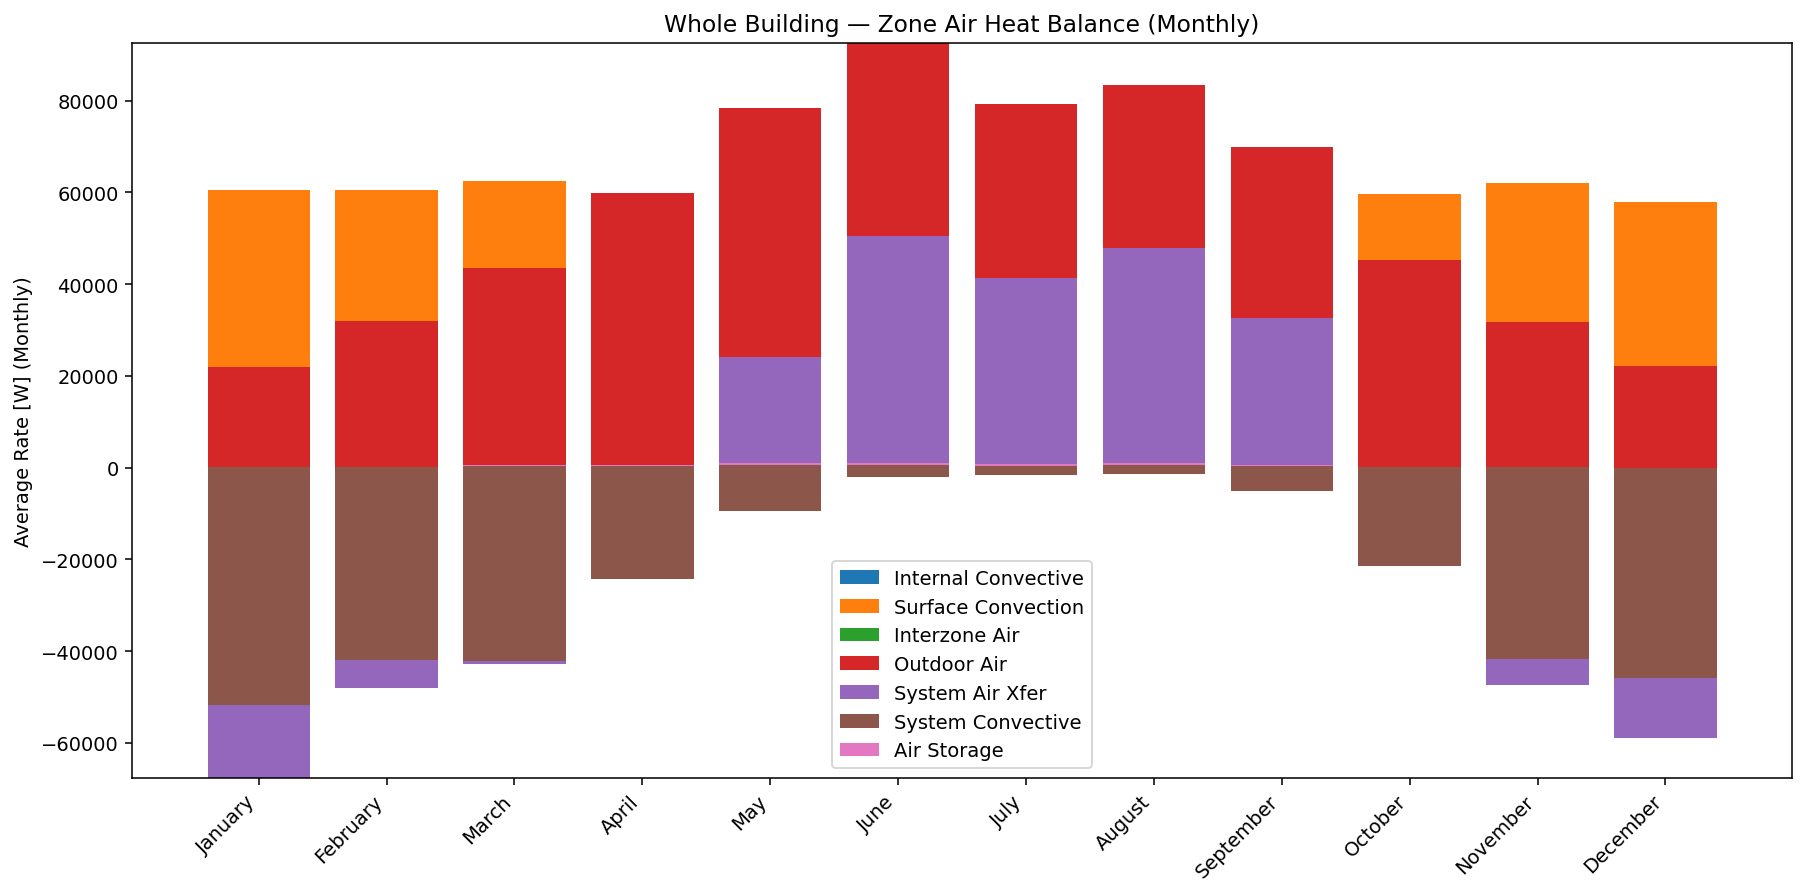

🎯 Zones selected: ZONE1-1_ATRIUM_C54B7226


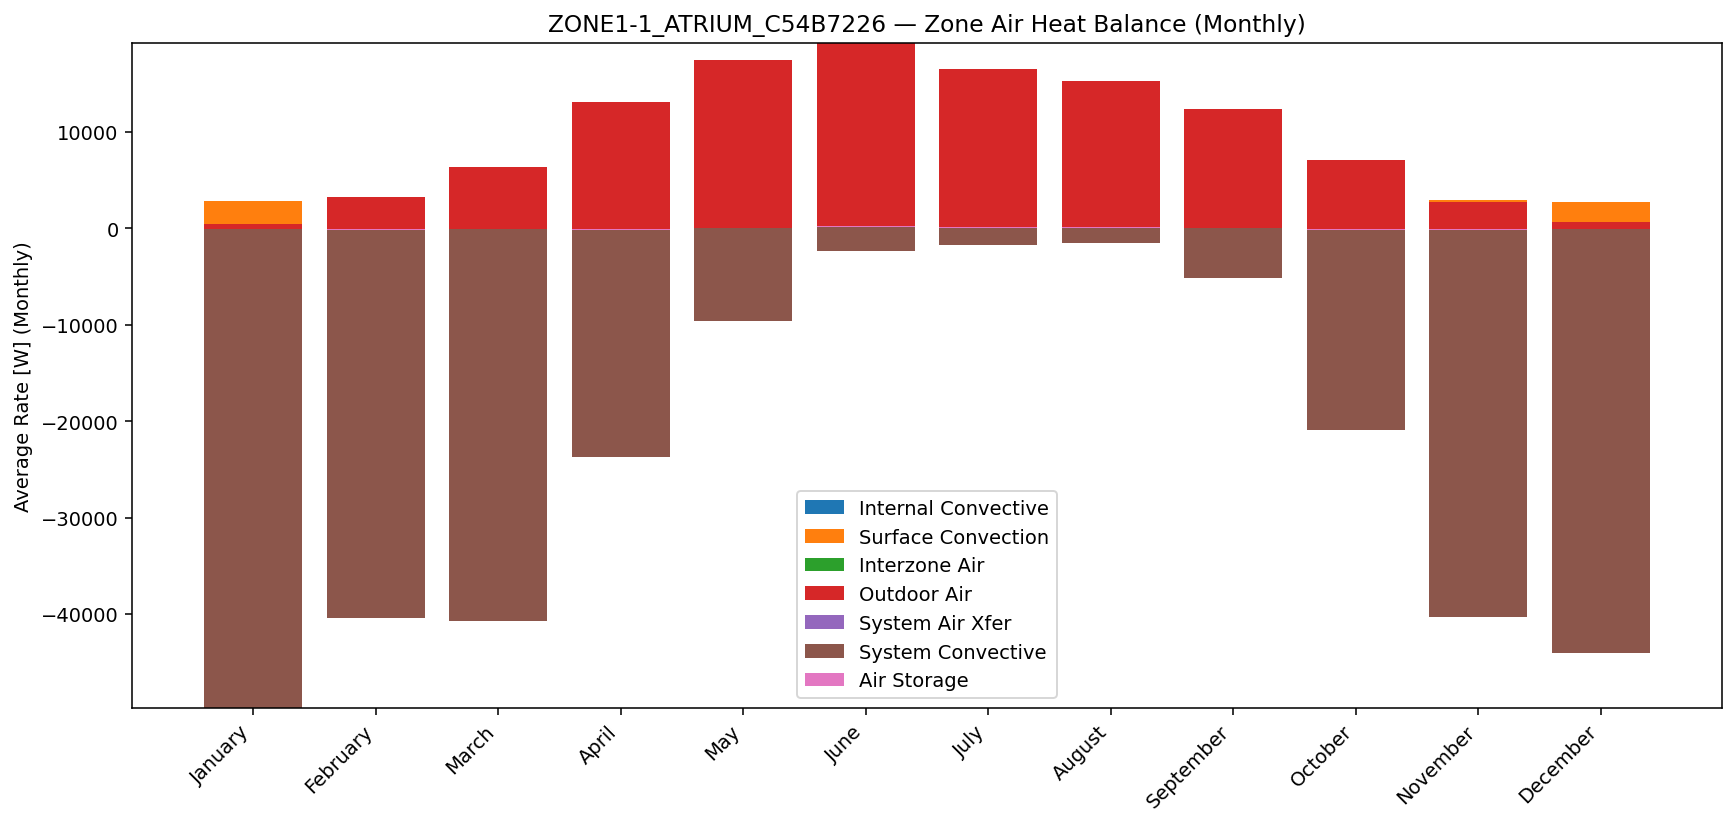

Done.


In [1]:
# JUPYTER — Whole-building & per-zone monthly plots (robust to subhourly CSV without year)
# ---------------------------------------------------------------------------------------
# • Lists all zones
# • Works with Monthly or subhourly data
# • Aggregates to MONTHLY (W avg or J energy)
# • Target zones by exact name or regex

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.dpi"] = 140

# ---------------- User knobs ----------------
CSV_PATH = Path("1/eplusout.csv")   # <— your file
OUTDIR = Path("./plots_building")          # images & zone list
AS_ENERGY = False                          # False: monthly avg [W]; True: monthly energy [J] (subhourly only)
PLOT_BUILDING = True
PLOT_SELECTED_ZONES = True
TARGET_ZONES = [r"^ZONE1-1_ATRIUM_.*$"]    # names or regex; [] ⇒ none
CASE_INSENSITIVE = True
# --------------------------------------------

wanted_map = {
    "Internal Convective": "Zone Air Heat Balance Internal Convective Heat Gain Rate [W]",
    "Surface Convection": "Zone Air Heat Balance Surface Convection Rate [W]",
    "Interzone Air": "Zone Air Heat Balance Interzone Air Transfer Rate [W]",
    "Outdoor Air": "Zone Air Heat Balance Outdoor Air Transfer Rate [W]",
    "System Air Xfer": "Zone Air Heat Balance System Air Transfer Rate [W]",
    "System Convective": "Zone Air Heat Balance System Convective Heat Gain Rate [W]",
    "Air Storage": "Zone Air Heat Balance Air Energy Storage Rate [W]",
    # Deviation often missing at coarse timesteps → optional
    "Sys Sensible Heat": "Zone Air System Sensible Heating Rate [W]",
    "Sys Sensible Cool": "Zone Air System Sensible Cooling Rate [W]",
}

month_name = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",
              7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}

def detect_header_row(csv_path: Path) -> int:
    idx = None
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as fh:
        for i, line in enumerate(fh):
            low = line.lower()
            if ("date/time" in low) or ("date time" in low) or low.startswith("datetime") or low.startswith("time,"):
                idx = i; break
    return 0 if idx is None else idx

def read_eplus(csv_path: Path) -> pd.DataFrame:
    header_idx = detect_header_row(csv_path)
    return pd.read_csv(csv_path, header=header_idx, engine="python", on_bad_lines="skip", skip_blank_lines=True)

def find_dt_col(df: pd.DataFrame):
    for c in df.columns:
        cl = str(c).strip().lower()
        if cl in ["date/time", "date time", "datetime", "time"]:
            return c
    for c in df.columns:
        if "date" in str(c).lower() and "time" in str(c).lower():
            return c
    return None

def split_zone_and_var(col: str):
    if not isinstance(col, str): return (None, None, None)
    # Expected: "<ZONE>:<var text>(Frequency?)"
    if ":" in col:
        zone, rest = col.split(":", 1)
        zone = zone.strip()
        m = re.search(r"\(([^)]+)\)\s*$", rest)
        freq = m.group(1) if m else None
        body = rest[:m.start()].strip() if m else rest.strip()
    else:
        # fallback: find variable token anywhere, take prefix as zone
        for full in wanted_map.values():
            idx = col.find(full)
            if idx != -1:
                zone = col[:idx].strip(" :-")
                freq = None
                body = full
                break
        else:
            return (None, None, None)
    for key, full in wanted_map.items():
        if full in body:
            return (zone, key, freq)
    return (None, None, None)

def build_meta(df: pd.DataFrame) -> pd.DataFrame:
    cols = [c for c in df.columns if isinstance(c, str)]
    recs = []
    for c in cols:
        z, key, freq = split_zone_and_var(c)
        if z and key:
            recs.append({"column": c, "zone": z, "var_key": key, "frequency": freq})
    return pd.DataFrame.from_records(recs)

def parse_month_num(series: pd.Series) -> pd.Series:
    """Robust month extractor:
       1) try normal datetime
       2) if fails (no year), regex the 'MM/DD' at start
    """
    dt = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
    if dt.notna().any():
        return dt.dt.month
    # e.g. " 01/31 24:00:00" → 1
    return series.astype(str).str.extract(r"^\s*(\d{2})/")[0].astype(int)

def to_long(df: pd.DataFrame, meta: pd.DataFrame, dt_col: str) -> pd.DataFrame:
    val = df[[dt_col] + list(meta["column"])].copy()
    # Month number (works for monthly strings or subhourly without year)
    val["_month_num"] = parse_month_num(val[dt_col])
    # For energy integration when subhourly: estimate a typical step seconds if datetimes parse
    parsed = pd.to_datetime(val[dt_col], errors="coerce", infer_datetime_format=True)
    if parsed.notna().any():
        ts = parsed.sort_values().unique()
        step = pd.Series(ts).diff().median() if len(ts) > 1 else pd.Timedelta(seconds=np.nan)
        val["_step_seconds"] = step.total_seconds() if pd.notna(step) else np.nan
    else:
        val["_step_seconds"] = np.nan
    long = val.melt(id_vars=[dt_col, "_month_num", "_step_seconds"],
                    var_name="column", value_name="value")
    long = long.merge(meta, on="column", how="left").dropna(subset=["var_key"])
    return long

def monthly_aggregate(long: pd.DataFrame, as_energy: bool) -> pd.DataFrame:
    if as_energy and long["_step_seconds"].notna().any():
        long["_contrib"] = long["value"] * long["_step_seconds"]
        agg = long.groupby(["zone","_month_num","var_key"], as_index=False)["_contrib"].sum()
        agg = agg.rename(columns={"_contrib": "value"})
    else:
        # monthly average rate (works for monthly or subhourly)
        agg = long.groupby(["zone","_month_num","var_key"], as_index=False)["value"].mean()
    agg["_month_name"] = agg["_month_num"].map(month_name)
    return agg

def list_zones(meta: pd.DataFrame, outdir: Path):
    zones = sorted(meta["zone"].unique())
    outdir.mkdir(parents=True, exist_ok=True)
    p = outdir / "zones_included.txt"
    with open(p, "w", encoding="utf-8") as f:
        for z in zones: f.write(f"{z}\n")
    print(f"✅ Zones found ({len(zones)}). First few:")
    print(", ".join(zones[:12]) + (" ..." if len(zones) > 12 else ""))
    print(f"(Full list saved: {p})")
    return zones, p

def zone_selector(zones_all, patterns, ci=True):
    if not patterns: return []
    flags = re.IGNORECASE if ci else 0
    picks = []
    for z in zones_all:
        for pat in patterns:
            if re.search(pat, z, flags=flags):
                picks.append(z); break
    return sorted(set(picks))

# ---------- Plot helpers ----------
def plot_building(building_month_df, as_energy: bool):
    lab = "Energy [J] (Monthly)" if AS_ENERGY else "Average Rate [W] (Monthly)"
    balance_vars = ["Internal Convective","Surface Convection","Interzone Air",
                    "Outdoor Air","System Air Xfer","System Convective","Air Storage"]
    bld = (building_month_df.groupby(["_month_num","var_key"], as_index=False)["value"].sum())
    piv = (bld[bld["var_key"].isin(balance_vars)]
           .pivot(index="_month_num", columns="var_key", values="value")
           .fillna(0.0).sort_index())
    if piv.empty:
        print("⚠️ Whole-building pivot empty — check variable matching.")
        return
    labels = [month_name[i] for i in piv.index]
    fig = plt.figure(figsize=(13, 6.5))
    bottom = np.zeros(len(piv))
    for v in balance_vars:
        if v in piv.columns:
            plt.bar(labels, piv[v].values, bottom=bottom, label=v)
            bottom = bottom + piv[v].values
    plt.xticks(rotation=45, ha="right"); plt.ylabel(lab)
    plt.title("Whole Building — Zone Air Heat Balance (Monthly)")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_zone(zname, monthly_df, as_energy: bool):
    lab = "Energy [J] (Monthly)" if AS_ENERGY else "Average Rate [W] (Monthly)"
    balance_vars = ["Internal Convective","Surface Convection","Interzone Air",
                    "Outdoor Air","System Air Xfer","System Convective","Air Storage"]
    sub = monthly_df[monthly_df["zone"] == zname]
    piv = (sub[sub["var_key"].isin(balance_vars)]
           .pivot(index="_month_num", columns="var_key", values="value")
           .fillna(0.0).sort_index())
    if piv.empty:
        print(f"(skip) No data for {zname}"); return
    labels = [month_name[i] for i in piv.index]
    fig = plt.figure(figsize=(12.5, 6))
    bottom = np.zeros(len(piv))
    for v in balance_vars:
        if v in piv.columns:
            plt.bar(labels, piv[v].values, bottom=bottom, label=v)
            bottom = bottom + piv[v].values
    plt.xticks(rotation=45, ha="right"); plt.ylabel(lab)
    plt.title(f"{zname} — Zone Air Heat Balance (Monthly)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------------- RUN ----------------
OUTDIR.mkdir(parents=True, exist_ok=True)

df = read_eplus(CSV_PATH)
dt_col = find_dt_col(df)
if dt_col is None:
    raise ValueError("No Date/Time column found.")

meta = build_meta(df)
if meta.empty:
    raise ValueError("No Zone Air Heat Balance variables found.")

zones_all, zones_file = list_zones(meta, OUTDIR)

long = to_long(df, meta, dt_col)
monthly_all = monthly_aggregate(long, AS_ENERGY)

print("Rows after monthly aggregation:", len(monthly_all))
print("Sample components:", sorted(monthly_all['var_key'].unique())[:8])

if PLOT_BUILDING:
    plot_building(monthly_all, AS_ENERGY)

if PLOT_SELECTED_ZONES and TARGET_ZONES:
    chosen = zone_selector(zones_all, TARGET_ZONES, CASE_INSENSITIVE)
    if not chosen:
        print("⚠️ No zones matched TARGET_ZONES; try printing `zones_all[:20]` to see names.")
    else:
        print("🎯 Zones selected:", ", ".join(chosen))
        for z in chosen:
            plot_zone(z, monthly_all, AS_ENERGY)

print("Done.")
